# Análise de cenário dos partidos politico na câmara de deputados 

Essa análise tem como objetivo entender como está o cenário dos partidos políticos na câmara dos deputados do Brasil. 

Pontos de análise:

1) Partidos mais relevantes na câmara;

2) Vieses ideológicos dos partidos; 

3) Influencia do Centrão na câmara dos deputados; 

4) Definição de uma regra para eliminação de partidos; 

5) Impacto dessa regra no dataset. 



In [1]:
#importação da bibliotecas 


import project_utils as pu 
import pandas as pd 
import seaborn as sns
import datetime as dt 

engine = pu.get_conection()

/home/andre/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#rodando query 
query = 'select * from silver.deputados'
df = pd.read_sql(query,con=engine)

## Tratamento de dados 

In [3]:
#agrupando o df em dt de inicio da legislatura , partido e numero de deputados 
df_partidos = df[['dt_inicio_legslatuara','siglaPartido','id']]
df_partidos = df_partidos.groupby(['dt_inicio_legslatuara','siglaPartido']).count()
df_partidos = df_partidos.reset_index()
df_partidos = df_partidos.rename(columns={'siglaPartido':'siglaPartido', 'dt_inicio_legslatuara':'dt_inicio_legslatuara', 'id':'n_deputados'})

In [4]:
df_partidos.head()

,dt_inicio_legslatuara,siglaPartido,n_deputados
0,1885-02-11,PL*,1
1,1891-06-10,PNI,1
2,1894-04-18,PNI,1
3,1897-04-18,PNI,1
4,1897-04-18,PRM,3


In [5]:
#criação do rank dos partido por legislatura 
df_partidos['rn'] = df_partidos.sort_values(['n_deputados'],ascending=[False])\
    .groupby(['dt_inicio_legslatuara']).cumcount() +1


In [6]:
# criando um dataset de suporte para entender a evolução dos partidos e calcular a representação dos partidos em suas respectivas legislaturas 
df_tot_lesgislaturas = df[['dt_inicio_legslatuara','id']]
df_tot_lesgislaturas = df_tot_lesgislaturas.groupby(['dt_inicio_legslatuara']).count()
df_tot_lesgislaturas = df_tot_lesgislaturas.reset_index()
df_tot_lesgislaturas = df_tot_lesgislaturas.rename(columns={'dt_inicio_legslatuara':'dt_inicio_legslatuara', 'id':'n_deputados'})

In [7]:
df_tot_lesgislaturas.head()

,dt_inicio_legslatuara,n_deputados
0,1826-04-29,107
1,1830-04-25,121
2,1834-04-25,124
3,1838-04-25,121
4,1842-04-25,121


In [8]:
# junção dos datacets e criação do percentual de cada partido em cada legislatura 
df_partidos = df_partidos.merge(df_tot_lesgislaturas,left_on='dt_inicio_legslatuara',right_on='dt_inicio_legslatuara')
df_partidos = df_partidos.rename(
    columns={'dt_inicio_legslatuara':'dt_inicio_legslatuara', 'siglaPartido':'siglaPartido','n_deputados_x':'n_deputados_partido'
            ,'rn':'posicao_do_partido','n_deputados_y':'n_deputados_legilatura'}
)
df_partidos['percent_legislatura'] = (df_partidos.n_deputados_partido/df_partidos.n_deputados_legilatura)*100

In [9]:
df_partidos.head()

,dt_inicio_legslatuara,siglaPartido,n_deputados_partido,posicao_do_partido,n_deputados_legilatura,percent_legislatura
0,1885-02-11,PL*,1,1,127,0.787402
1,1891-06-10,PNI,1,1,239,0.418410
2,1894-04-18,PNI,1,1,230,0.434783
3,1897-04-18,PNI,1,2,224,0.446429
4,1897-04-18,PRM,3,1,224,1.339286


In [10]:
df_top_five = df_partidos[df_partidos['posicao_do_partido'] <= 5]
df_top_five = df_top_five[['dt_inicio_legslatuara','percent_legislatura']].groupby(['dt_inicio_legslatuara']).sum()
df_top_five = df_top_five.reset_index()
df_top_five.head()

,dt_inicio_legslatuara,percent_legislatura
0,1885-02-11,0.787402
1,1891-06-10,0.418410
2,1894-04-18,0.434783
3,1897-04-18,1.785714
4,1900-04-18,1.673640


In [11]:
# craição de uma flag apontando se o partido é do centrão 
# definição segundo o site politisice e g1 
# https://bit.ly/2UEpNEp #https://glo.bo/3kgZCwk
centrao = ['PP','REPUBLICANOS','SOLIDARIEDADE','PTB','PSD','MDB','DEM','PROS','PSC','AVANTE','PATRIOTA']
df_partidos['flag_centrao'] = df_partidos.siglaPartido.apply(lambda x: 'centrao' if x in centrao else None)
df['flag_centrao'] = df.siglaPartido.apply(lambda x: 'centrao' if x in centrao else None)

## Análises 

## Contexto 

Antes de entrar nas perguntas levantadas anteriormente, precisamos entender qual é o contexto geral da câmara dos deputados. 

Text(0.5, 1.0, 'Evolução do numero de deputados nos anos')

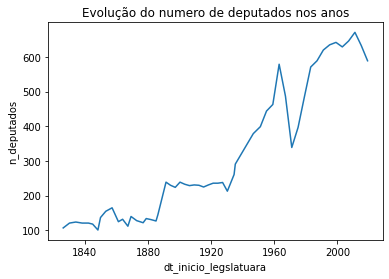

In [12]:
ax = sns.lineplot(data= df_tot_lesgislaturas,x='dt_inicio_legslatuara',y = 'n_deputados')
ax.set_title('Evolução do numero de deputados nos anos')

Olhando a evolução do número de deputados por legislatura vemos uma escalada muito grande saindo por volta de 
250 deputados no começo do século passado para mais de 600 na legislatura de 2015, seguindo para uma pequena queda na legislatura atual. 

Outro ponto interessante é a queda abrupta seguida de uma retomada abrupta, durante os anos 60-70. Isso é um impacto claro da ditadura militar que estava ocorrendo no pais. 


Text(0.5, 1.0, 'Evolução do numero de partidos ao longo dos anos')

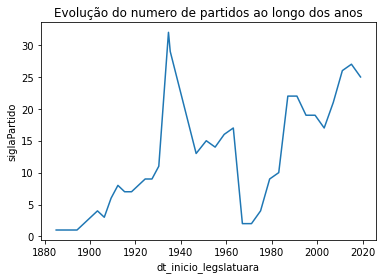

In [13]:
ax = sns.lineplot(data = df_partidos.groupby('dt_inicio_legslatuara').siglaPartido.nunique().reset_index()
             ,x = 'dt_inicio_legslatuara',y = 'siglaPartido')
ax.set_title('Evolução do numero de partidos ao longo dos anos')

Se olharmos para o volume de partidos vemos o mesmo efeito, uma escalada constante do número de partidos, com exceção de alguns pontos nos anos 40 e da ditadura militar que houve no país. 

Nessa visão, o período da ditadura fica mais evidente, principalmente devido à retomada no número de deputados durante a ditadura, mas não do número de partidos que sobe muito mais lentamente. 

## Partidos mais relevantes da câmara dos deputados 

Antes de olhar diretamente para os partidos, vamos entender como o poder esta centralisado nos principais partidos. 

Text(0.5, 1.0, 'Representatividade do principal partido da câmara dos deputados ao longo dos anos')

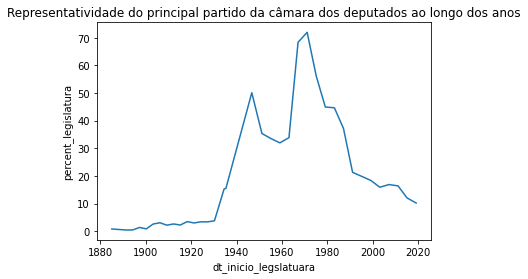

In [14]:
ax =sns.lineplot(data=df_partidos[df_partidos['posicao_do_partido']==1]
                 ,x='dt_inicio_legslatuara',y='percent_legislatura')
ax.set_title('Representatividade do principal partido da câmara dos deputados ao longo dos anos')

Aqui vemos um cenário mais proeminente no impacto da ditadura, onde um só partido controlava 70% da cãmara dos deputados. 

Já no mandato atual vemos um cenário oposto, onde o principal partido tem no máximo 10% da câmara dos deputados, o que gera uma maior diluição do poder, e uma abertura para que estruturas suprapartidárias consigam agregar esses votos para aprovar leis. 

Text(0.5, 1.0, 'Representatividade dos top 5 partidos da câmara dos deputados ao longo dos anos')

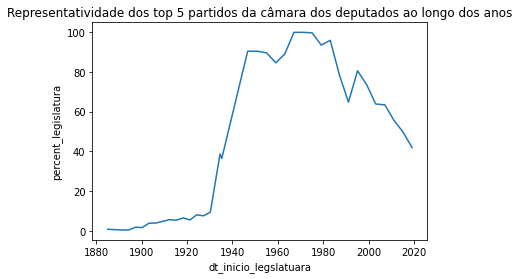

In [15]:
ax =sns.lineplot(data=df_top_five
                 ,x='dt_inicio_legslatuara',y='percent_legislatura')
ax.set_title('Representatividade dos top 5 partidos da câmara dos deputados ao longo dos anos')

A mesma análise se mostra verdadeira nos top 5 partidos. Há uma queda da representatividade dos principais partidos brasileiros, junto com um aumento no número de partidos representados na câmara dos deputados. 

Text(0.5, 1.0, 'Representatividade dos partidos na legislatura de 2019')

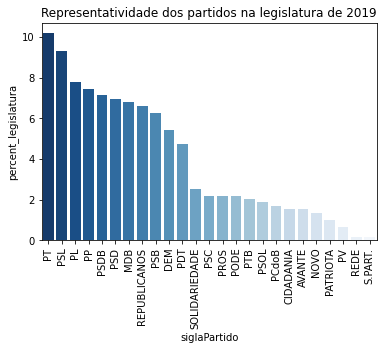

In [16]:
ax = sns.barplot(data=df_partidos[df_partidos['dt_inicio_legslatuara']==dt.date(2019,2,1)].sort_values('percent_legislatura',ascending=False),
                 x='siglaPartido',y='percent_legislatura',palette='Blues_r')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Representatividade dos partidos na legislatura de 2019')

Quando visualizamos a legislatura atual, temos um exemplo mais claro do que foi discutido anteriormente.

Há 14 partidos políticos cujo total de seus deputados não representam mais que 4,5% do total na câmara. 

Além disso, existe uma clara quebra entre os partidos com mais de 4.5% na câmara e aqueles com percentuais menores. 

Text(0.5, 1.0, 'Representatividade dos partidos na legislatura de 2015')

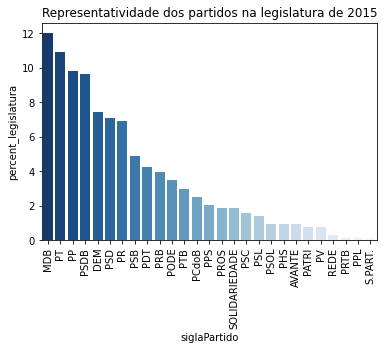

In [17]:
ax = sns.barplot(data=df_partidos[df_partidos['dt_inicio_legslatuara']==dt.date(2015,2,1)].sort_values('percent_legislatura',ascending=False),
                 x='siglaPartido',y='percent_legislatura',palette='Blues_r')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Representatividade dos partidos na legislatura de 2015')

Quando olhamos para o mandato anterior, vemos algumas mudanças interessantes.

O MDB apresenta uma queda significativa saindo de 12% para 7% e indo do principal partido para 7º.

Vemos uma ascensão do PSL e PL, principalmente do PSL que tinha por volta de 2% e em uma eleição foi para 8%.

Temos também uma diluição maior dos partidos políticos, principalmente quando olhamos para partidos com mais de 4,5% dos deputados, sendo que em 2015 tinhamos 7 partidos acima dessa barreira, já em 2019 temos 11 partidos. 

# Vieses ideológicos dos partidos

Text(0.5, 1.0, 'Alinhamento político da legislatura atual na câmara dos deputados ')

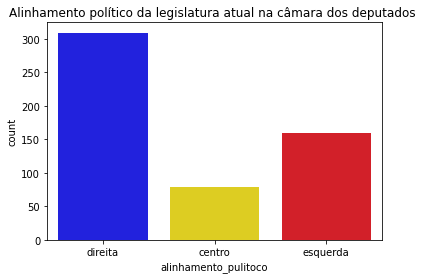

In [18]:
ax = sns.countplot(data = df[df['dt_inicio_legslatuara']==dt.date(2019,2,1)]
                   ,x= 'alinhamento_pulitoco',palette=['#0303fc','#fce703','#f0020e'])
ax.set_title('Alinhamento político da legislatura atual na câmara dos deputados ')

Quando olhamos para o viés ideológico na câmera dos deputados, vemos um ambiente que tende bastante para a direita, provavelmente um efeito da eleição do Bolsonaro, e do crescimento do PSL e do PL. 

## Influência do Centrão na câmara dos deputados

In [19]:
df_partidos_centrao = df_partidos[df_partidos['flag_centrao']=='centrao']
df_partidos_centrao = df_partidos_centrao[['dt_inicio_legslatuara','percent_legislatura']]
df_partidos_centrao = df_partidos_centrao.groupby(by='dt_inicio_legslatuara').sum().reset_index()

Text(0.5, 1.0, 'Representatividade do Centrão ao longo dos anos')

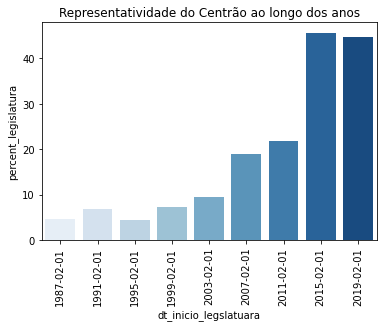

In [20]:
# vemos uma escalada na representatividade do centrão apos a sua criação durante a acembreia constituinte de 19877
# tendo o seu apicie no segundo mandato da dilma.
ax = sns.barplot(data=df_partidos_centrao[df_partidos_centrao['dt_inicio_legslatuara']>= dt.date(1987,1,1)],
            x='dt_inicio_legslatuara',y='percent_legislatura',palette='Blues')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Representatividade do Centrão ao longo dos anos')

Ao olharmos para o Centrão, vemos um aumento da sua representatividade, ao mesmo tempo em que se percebe uma falta de repesentatividade dos principais partidos. Observamos um crescimento acentuado da representação justamente no segundo mandato de Dilma e uma estabilidade no mandato de Bolsonaro.

# Insights 

### O poder esta diluído 
Notamos um crecimento do número de partidos na câmara dos deputados, ao mesmo tempo há uma queda da representatividade dos principais partidos. Isso pode ser problemático uma vez que há mais frentes de "negociação" para que um governo consiga uma maioria na câmara. O que por outro lado também pode ser positivo pois aumentam a representatividade de um maior número de grupos ideológicos. 

### O Centrão e a direita 
Considerando o cenário a cima, percebemos a importância de estruturas suprapartidárias. Hoje vemos uma câmara majoritariamente de direita, e com uma representatividede muito grande do centrão, justamente cobrindo essa falta de poder dos grandes partidos. 